<a href="https://colab.research.google.com/github/mridul-gupta-ds/Data-Science/blob/master/temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install googletrans
!pip install autocorrect

In [ ]:
import pandas as pd
from autocorrect import spell
from googletrans import Translator
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [ ]:
df_raw = pd.read_excel("/content/drive/My Drive/SecondCup/data/2019_survey_comments.xlsx")

In [ ]:
df = df_raw.copy()

In [ ]:
df.head()

,Respondents,Response Date,Responses,Tags,Sentiment
0,8965,Apr 01 2018 01:08 PM,Maple latte was delicious,NaN,Positive
1,8964,Apr 01 2018 01:18 PM,second cup needs a DEDICATED membership card a...,NaN,Negative
2,8963,Apr 01 2018 03:26 PM,"The service at this location is good, BUT the ...",NaN,Negative
3,8962,Apr 01 2018 05:21 PM,Seating was very limited and when we found a s...,NaN,Negative
4,8961,Apr 01 2018 06:31 PM,I’m all about customer service. And in the pas...,NaN,Positive


In [ ]:
!pip install spacy_langdetect

In [ ]:
# Drop NULL comments
df.drop(df[df['Responses'].isnull()].index,inplace=True)

In [ ]:
import spacy
from spacy_langdetect import LanguageDetector
nlp = spacy.load('en')
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)
#text = df['Responses'][0]

def language_detector(text):
  doc = nlp(text)
  # document level language detection. Think of it like average language of the document!
  return doc._.language['language']

df['Language'] = df['Responses'].apply(lambda x: language_detector(x))

In [ ]:
df.to_excel("data_language.xlsx")

In [ ]:
# Filter on English and French detected comments
df = df[(df['Language']=='en') | (df['Language']=='fr')]

In [ ]:
df.shape

(18986, 6)

In [ ]:
##Translate from french to english
translator = Translator()

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

def translate_from_french(response,lang):
    #print(response)
    if lang == 'fr':
      return translator.translate(deEmojify(response)).text
    else:
      return deEmojify(response)

In [ ]:
df['Responses_Tenaslated'] = df.apply(lambda row: translate_from_french(row['Responses'],row['Language']), axis=1)

In [ ]:
df.to_excel("data_translated.xlsx")

In [ ]:
filterdf = df[df['Sentiment']=='Positive']

In [ ]:
# Convert to list
data = filterdf.Responses_Tenaslated.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Maple latte was delicious ']


In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['maple', 'latte', 'was', 'delicious']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['maple', 'latte', 'was', 'delicious']


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['make','starbuck','work','people','cafe','day','cold','year','month'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[[]]


In [ ]:
data_words_bigrams

[['maple', 'latte', 'delicious'],
 ['im',
  'customer',
  'service',
  'past',
  'wasnt',
  'alway',
  'happy',
  'lately',
  'improved',
  'greatly',
  'staff',
  'takes',
  'interest'],
 ['could',
  'add',
  'screen',
  'near',
  'speaker',
  'confirm',
  'order',
  'shediac',
  'nb',
  'location',
  'thank',
  'drinks',
  'better',
  'sb',
  'th'],
 ['visit',
  'good',
  'would',
  'like',
  'see',
  'second',
  'cup',
  'caf',
  'soutside',
  'edmonton'],
 ['greatest',
  'coffee',
  'shop',
  'second',
  'cup',
  'time',
  'shania',
  'amazing',
  'job'],
 ['fantastic', 'spot', 'go', 'stop', 'study'],
 ['location',
  'always',
  'friendly',
  'makes',
  'effort',
  'remember',
  'clients',
  'orders'],
 ['location',
  'always',
  'chooses',
  'drive_thru',
  'counter',
  'stood',
  'watched',
  'serve',
  'new',
  'cars',
  'asking',
  'order'],
 ['friendly', 'love', 'daily', 'visit'],
 ['second',
  'cup',
  'located',
  'shediac',
  'far',
  'preferred',
  'location',
  'coffee',


In [ ]:
data_lemmatized = remove_stopwords(data_lemmatized)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[]]


In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[]]

TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# using default tokenizer in TfidfVectorizer
tfidf = TfidfVectorizer(min_df=0.01, max_df=0.9, ngram_range=(1, 1)) #,max_features=1000,
mylist = []
for x in texts:
    ##print(x)
    ee = " ".join(x)
    mylist.append(ee)
features = tfidf.fit_transform(mylist)
pd.DataFrame(features.todense(),columns=tfidf.get_feature_names()).to_csv("tfidfscore.csv")
#print(pd.DataFrame(features.todense(),columns=tfidf.get_feature_names()).columns)

#LDA

In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.7" 2020-04-14
OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2020-06-13 06:54:08--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  12.0MB/s    in 1.3s    

2020-06-13 06:54:09 (12.0 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 

In [ ]:
from gensim.models.wrappers import LdaMallet

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('location', 0.26120689655172413),
   ('visit', 0.1622126436781609),
   ('owner', 0.04971264367816092),
   ('friend', 0.03836206896551724),
   ('morning', 0.03721264367816092),
   ('week', 0.022701149425287358),
   ('warm', 0.01853448275862069),
   ('change', 0.017816091954022988),
   ('girl', 0.017241379310344827),
   ('pleasure', 0.013793103448275862)]),
 (1,
  [('service', 0.16792051100070973),
   ('staff', 0.1078779276082328),
   ('friendly', 0.10177430801987225),
   ('customer', 0.08204400283889283),
   ('great', 0.060610361958836054),
   ('excellent', 0.05081618168914123),
   ('pleasant', 0.045990063875088714),
   ('efficient', 0.03520227111426544),
   ('smile', 0.034208658623136975),
   ('wonderful', 0.03207948899929028)]),
 (2,
  [('great', 0.17540322580645162),
   ('enjoy', 0.09879032258064516),
   ('place', 0.09086981566820276),
   ('nice', 0.09029377880184332),
   ('atmosphere', 0.05601958525345622),
   ('clean', 0.044642857142857144),
   ('tea', 0.02390552995391705)

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=4, limit=30, step=2)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


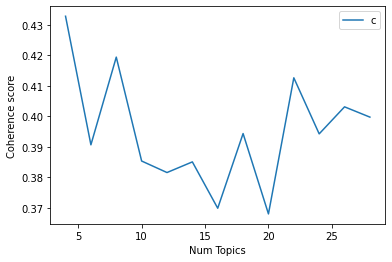

In [ ]:
import matplotlib.pyplot as plt

# Show graph
limit=30; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.4329
Num Topics = 6  has Coherence Value of 0.3907
Num Topics = 8  has Coherence Value of 0.4195
Num Topics = 10  has Coherence Value of 0.3854
Num Topics = 12  has Coherence Value of 0.3816
Num Topics = 14  has Coherence Value of 0.3851
Num Topics = 16  has Coherence Value of 0.3699
Num Topics = 18  has Coherence Value of 0.3944
Num Topics = 20  has Coherence Value of 0.3681
Num Topics = 22  has Coherence Value of 0.4127
Num Topics = 24  has Coherence Value of 0.3943
Num Topics = 26  has Coherence Value of 0.4032
Num Topics = 28  has Coherence Value of 0.3998


In [ ]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

[(0,
  '0.162*"location" + 0.126*"visit" + 0.060*"good" + 0.044*"amazing" + '
  '0.041*"owner" + 0.037*"pleasant" + 0.037*"experience" + 0.030*"morning" + '
  '0.028*"smile" + 0.021*"awesome" + 0.020*"happy" + 0.020*"barista" + '
  '0.016*"girl" + 0.013*"team" + 0.013*"manager" + 0.012*"start" + '
  '0.010*"mall" + 0.010*"hard" + 0.009*"lady" + 0.009*"family" + '
  '0.008*"exceptional" + 0.008*"reason" + 0.008*"enjoyable" + 0.006*"care" + '
  '0.006*"personable" + 0.006*"face" + 0.006*"accommodate" + 0.006*"feel" + '
  '0.006*"consistently" + 0.006*"part"'),
 (1,
  '0.053*"barista" + 0.051*"card" + 0.042*"reward" + 0.033*"point" + '
  '0.026*"find" + 0.022*"give" + 0.020*"drive" + 0.018*"week" + 0.017*"offer" '
  '+ 0.014*"add" + 0.014*"change" + 0.013*"bit" + 0.012*"price" + 0.011*"pay" '
  '+ 0.010*"prefer" + 0.010*"purchase" + 0.010*"app" + 0.009*"special" + '
  '0.009*"thing" + 0.009*"question" + 0.008*"big" + 0.008*"regular" + '
  '0.007*"window" + 0.007*"continue" + 0.007*"ready"

#Finding the dominant topic in each sentence


In [ ]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1250,"location, visit, good, amazing, owner, pleasan...",Maple latte was delicious
1,1,1.0,0.1492,"barista, card, reward, point, find, give, driv...",Im all about customer service. And in the past...
2,2,3.0,0.1480,"great, enjoy, place, nice, atmosphere, clean, ...",Could you add a screen near the speaker to con...
3,3,0.0,0.1458,"location, visit, good, amazing, owner, pleasan...",My visit was good! But would like see a few mo...
4,4,2.0,0.1473,"coffee, good, cup, shop, favourite, buy, bean,...",The greatest coffee shop and second cup of all...
5,5,3.0,0.1713,"great, enjoy, place, nice, atmosphere, clean, ...","Fantastic spot, my go-to stop before work or t..."
6,6,4.0,0.1473,"staff, friendly, helpful, efficient, remember,...","This location is always friendly, and makes an..."
7,7,5.0,0.1920,"drink, time, order, taste, latte, serve, long,...",This location always chooses the drive thru be...
8,8,6.0,0.1548,"love, beverage, food, back, option, treat, tea...",Very friendly - love my daily visit!
9,9,4.0,0.1577,"staff, friendly, helpful, efficient, remember,...",The second cup located in Shediac is by far my...


In [ ]:
df_dominant_topic.to_csv("main_positive_dominant_topic.csv")

#Find the most representative document for each topic

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2753,"location, visit, good, amazing, owner, pleasan...","The Second Cup I visited is a very busy one, s..."
1,1.0,0.3963,"barista, card, reward, point, find, give, driv...",I love this Second Cup in particular and will ...
2,2.0,0.3435,"coffee, good, cup, shop, favourite, buy, bean,...",That particular location is under new owners I...
3,3.0,0.3375,"great, enjoy, place, nice, atmosphere, clean, ...",Yes. There is a place to sit by the side door ...
4,4.0,0.2149,"staff, friendly, helpful, efficient, remember,...","The staff at this location are super friendly,..."


In [ ]:
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2753,"location, visit, good, amazing, owner, pleasan...","The Second Cup I visited is a very busy one, s..."
1,1.0,0.3963,"barista, card, reward, point, find, give, driv...",I love this Second Cup in particular and will ...
2,2.0,0.3435,"coffee, good, cup, shop, favourite, buy, bean,...",That particular location is under new owners I...
3,3.0,0.3375,"great, enjoy, place, nice, atmosphere, clean, ...",Yes. There is a place to sit by the side door ...
4,4.0,0.2149,"staff, friendly, helpful, efficient, remember,...","The staff at this location are super friendly,..."
5,5.0,0.4120,"drink, time, order, taste, latte, serve, long,...",I love your beverages and the employees are ty...
6,6.0,0.3101,"love, beverage, food, back, option, treat, tea...",Although the pumpkin spice loaf was pretty goo...
7,7.0,0.3056,"great, service, location, customer, store, exc...",2 hours before the shop is suppose to be close...


In [ ]:
sent_topics_sorteddf_mallet.to_csv("main_positive_most_representative_document_for_topic.csv")

#Topic distribution across documents

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"location, visit, good, amazing, owner, pleasan...",2048.0,0.1649
1.0,1.0,"barista, card, reward, point, find, give, driv...",1257.0,0.1012
2.0,3.0,"great, enjoy, place, nice, atmosphere, clean, ...",1866.0,0.1502
3.0,0.0,"location, visit, good, amazing, owner, pleasan...",1453.0,0.1170
4.0,2.0,"coffee, good, cup, shop, favourite, buy, bean,...",2049.0,0.1650
...,...,...,...,...
12416.0,5.0,"drink, time, order, taste, latte, serve, long,...",NaN,NaN
12417.0,4.0,"staff, friendly, helpful, efficient, remember,...",NaN,NaN
12418.0,6.0,"love, beverage, food, back, option, treat, tea...",NaN,NaN
12419.0,4.0,"staff, friendly, helpful, efficient, remember,...",NaN,NaN


In [ ]:
df_dominant_topics.to_csv("main_positive_topic_distribution_in_documents.csv")

#Word Cloud

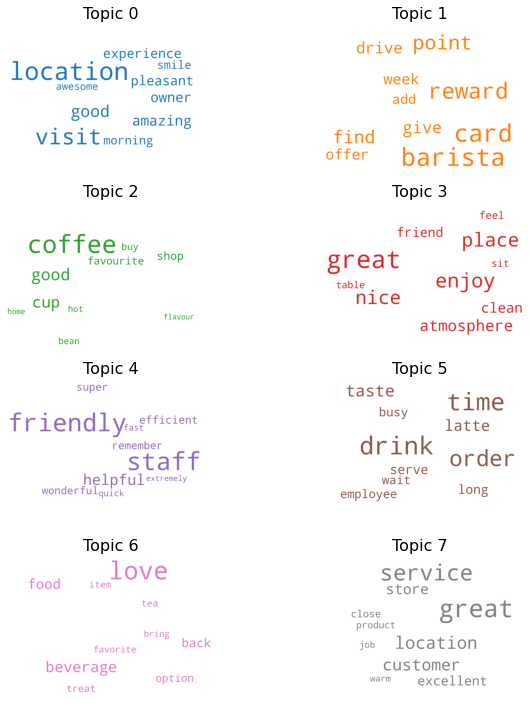

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#Word Counts of Topic Keywords

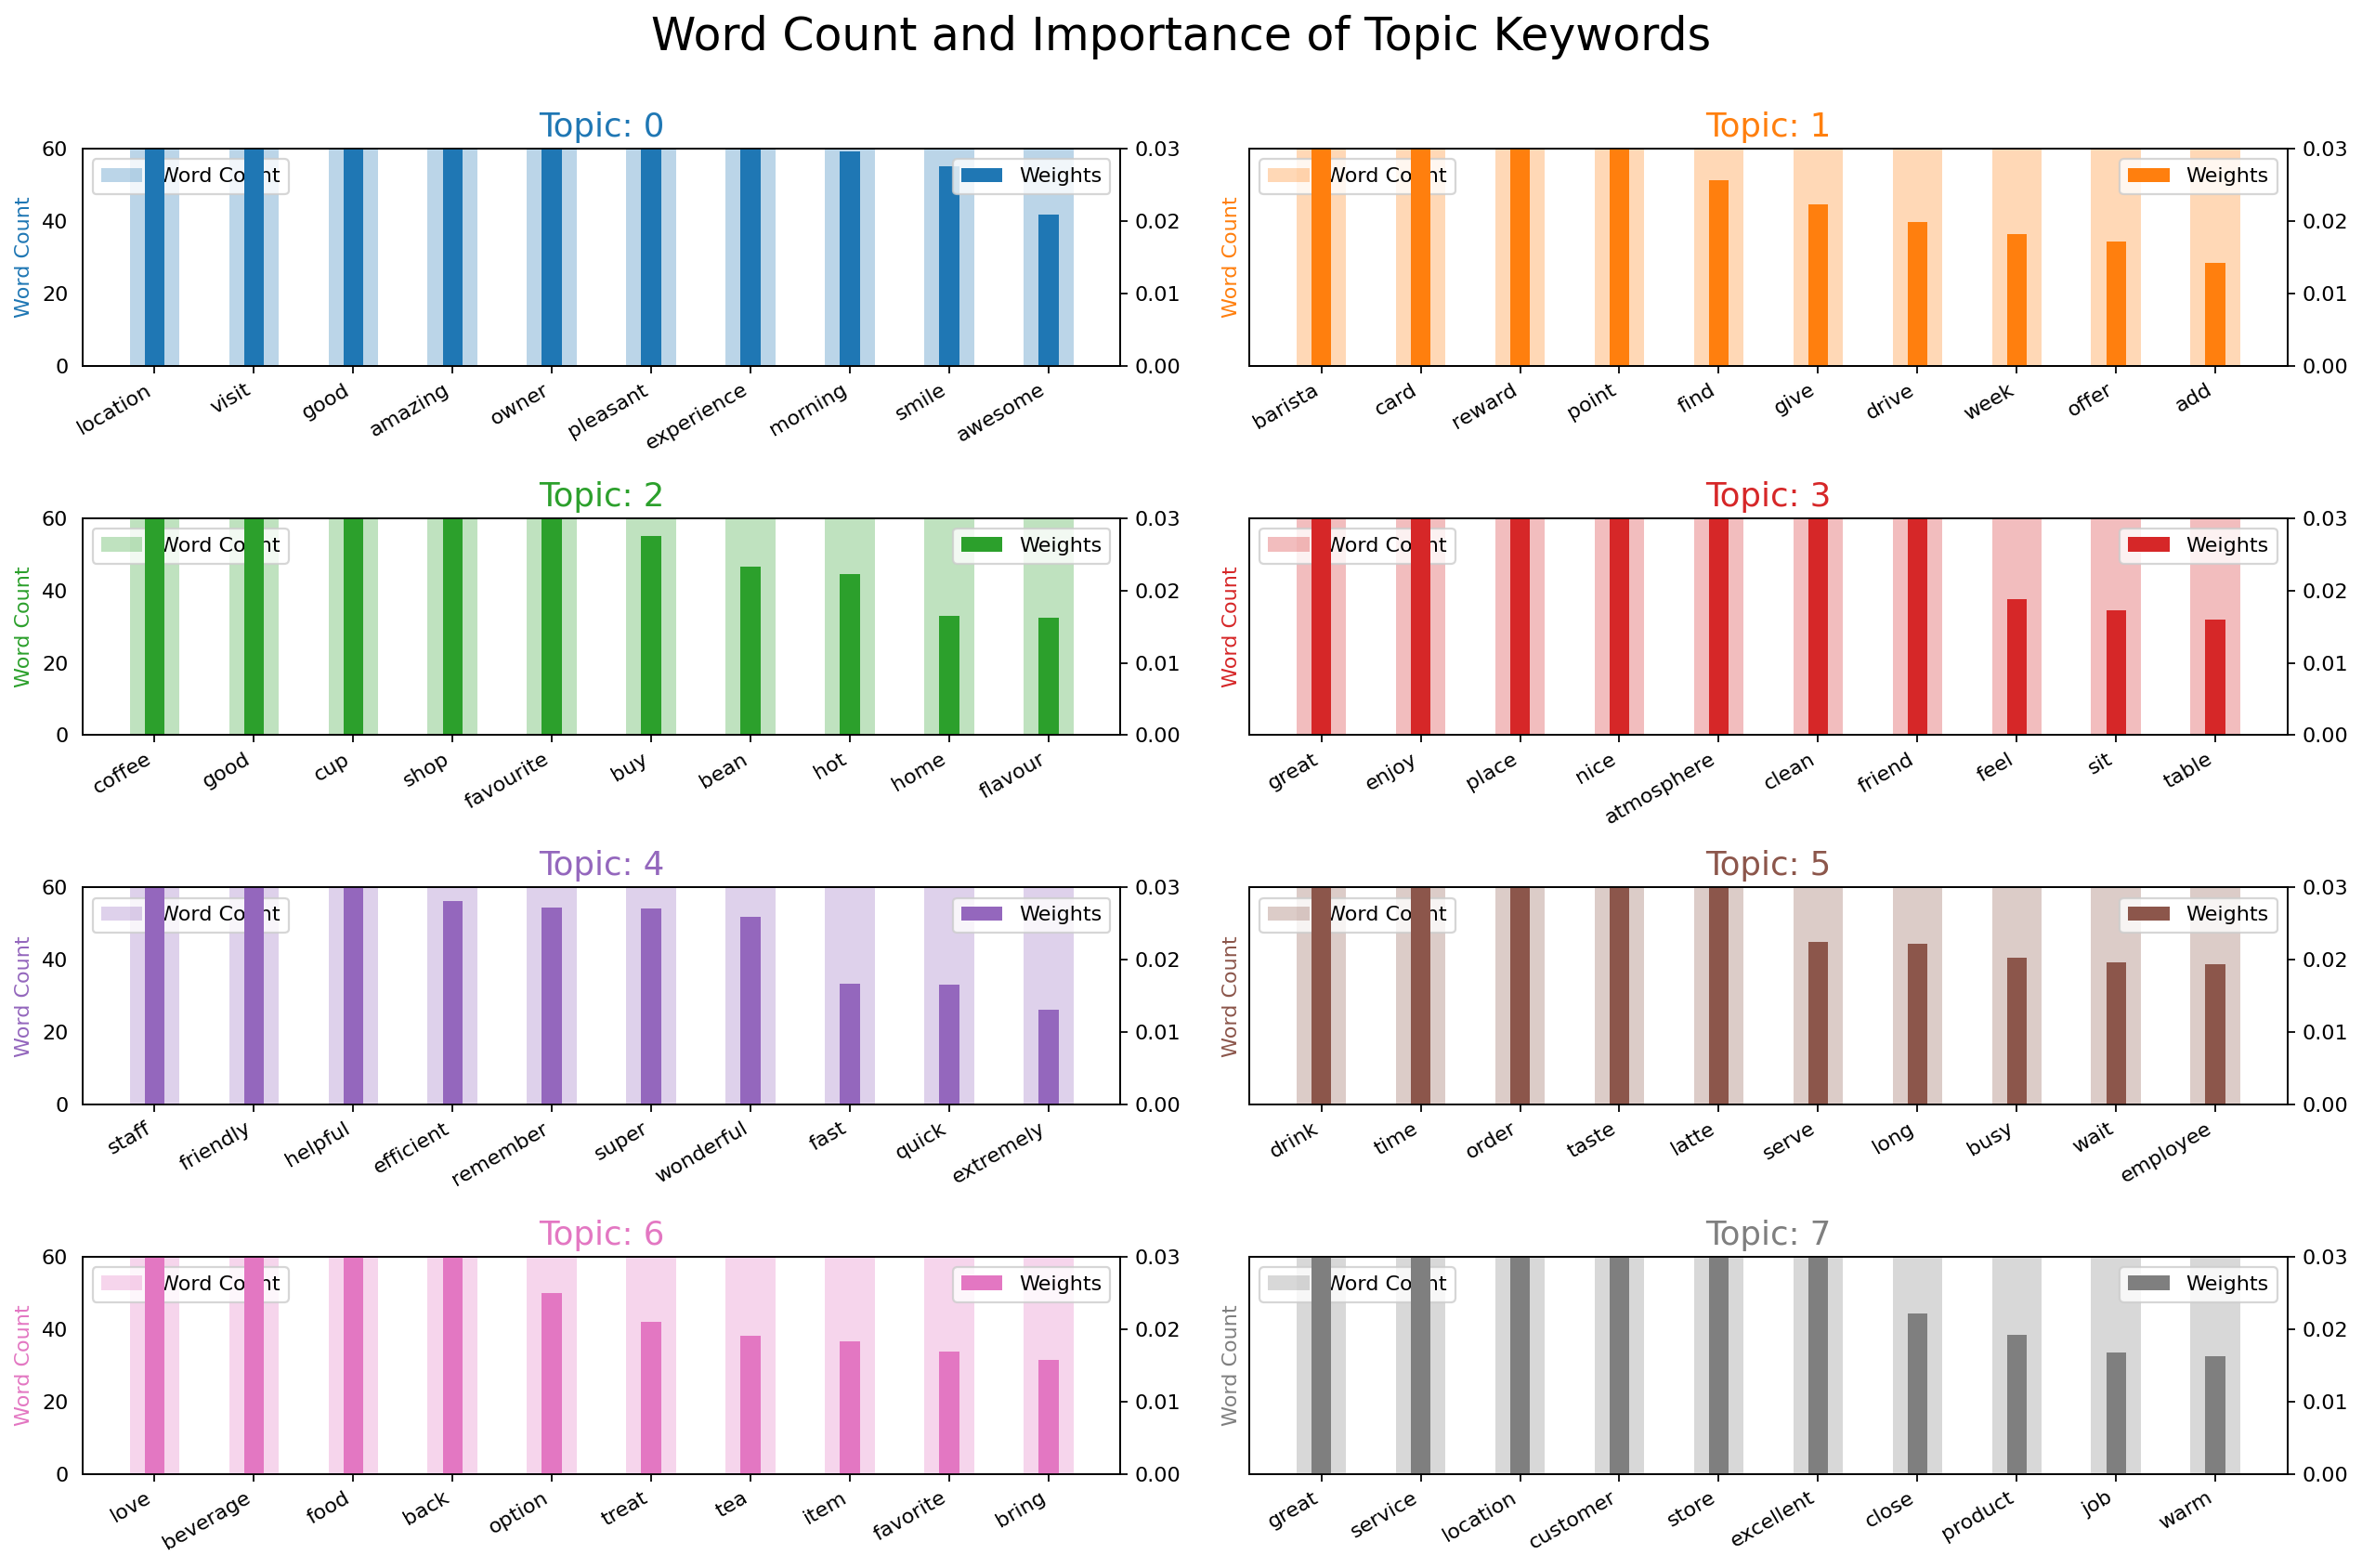

In [ ]:
from collections import Counter
topics = optimal_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 60)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

#PyLDA Vis


In [ ]:
!pip install pyLDAvis

In [ ]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model , corpus, dictionary=model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.000171 -0.000108       1        1  13.045667
5     -0.000722  0.000582       2        1  13.041770
2     -0.000028 -0.000493       3        1  12.507116
7      0.000093  0.000049       4        1  12.386953
3      0.000785  0.000997       5        1  12.369194
6      0.000773 -0.000622       6        1  12.353610
0     -0.000069 -0.000315       7        1  12.331362
4     -0.000660 -0.000090       8        1  11.964328, topic_info=              Term       Freq      Total Category  logprob  loglift
2932         laval  19.000000  19.000000  Default  30.0000  30.0000
1938         aware  20.000000  20.000000  Default  29.0000  29.0000
2823       royalty  20.000000  20.000000  Default  28.0000  28.0000
845       makeover  20.000000  20.000000  Default  27.0000  27.0000
3296   overlooking  19.000000  19.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
2066       chicken   2.990570  20.924611   Topic8  -8.2114   0.1778
216            sad   2.974214  20.606182   Topic8  -8.2169   0.1876
1791            ok   2.968782  20.571472   Topic8  -8.2187   0.1875
3735  congratulate   2.973792  20.755722   Topic8  -8.2170   0.1803
1295       traffic   2.998293  21.942250   Topic8  -8.2088   0.1329

[380 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
4015      1  0.101080   abuse
4015      2  0.151620   abuse
4015      3  0.151620   abuse
4015      4  0.101080   abuse
4015      5  0.101080   abuse
...     ...       ...     ...
2723      4  0.102550  yogurt
2723      5  0.102550  yogurt
2723      6  0.153825  yogurt
2723      7  0.102550  yogurt
2723      8  0.153825  yogurt

[2808 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 3, 8, 4, 7, 1, 5])